# B. Hyperparameters Optimization

From Part A, the MLP model with tanh activation function for the hidden layer performed the best 

In [1]:
"""MLP Implementation with Early Stopping, Dropout, and Validation

This code defines a Multi-Layer Perceptron class that supports:
- Multiple hidden layers
- Various activation functions (relu, sigmoid, tanh, softmax)
- Cross-entropy loss
- Dropout regularization
- Early stopping based on validation loss

"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data file path
train_file_path = 'THA2train.xlsx'
validation_file_path = 'THA2validate.xlsx'

# Function for pre-processing
def preprocess_data(df):
    X = np.array(df[['X_0', 'X_1']].values)  # Select specific feature columns
    y = np.zeros((X.shape[0], 2))
    for i in range(X.shape[0]):
        y[i, int(df['y'].values[i])] = 1
    X = X / np.max(X, axis=0)  # Normalize features
    return X, y

# Functions to load data
def load_train_data():
  return preprocess_data(pd.read_excel(train_file_path))

def load_validation_data():
    return preprocess_data(pd.read_excel(validation_file_path))

In [3]:
# Defining all activation functions and loss function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy(y, y_pred):
    # Add a small number to avoid log(0)
    return -np.sum(y * np.log(y_pred + 1e-9)) / y.shape[0]

def cross_entropy_derivative(y, y_pred):
    return y_pred - y

In [4]:
# Defining the MLP model
class MLP:
    """
    A Multi-Layer Perceptron class supporting multiple hidden layers, dropout,
    early stopping, and both training and validation loss tracking.
    """
    def __init__(self,
                 input_neurons,
                 hidden_layer_neurons,
                 output_neurons,
                 hidden_activation='relu',
                 output_activation='softmax',
                 loss_function='cross_entropy',
                 learning_rate=0.0001,
                 batch_size=64,
                 epochs=3000,
                 patience=200,
                 dropout_rate=0.0001
                ):
        """
        Initializing the MLP with given architecture and hyperparameters.
        """
        self.input_neurons = input_neurons
        self.hidden_layer_neurons = hidden_layer_neurons  # list of neurons in each hidden layer
        self.output_neurons = output_neurons

        # Assign activation functions
        self.hidden_activation_str = hidden_activation
        self.output_activation_str = output_activation
        self.hidden_activation, self.hidden_activation_derivative = self._get_activation(hidden_activation)
        self.output_activation, _ = self._get_activation(output_activation)

        # Assign loss function
        self.loss_function_str = loss_function
        self.loss_function = self._get_loss_function(loss_function)
        self.loss_function_derivative = self._get_loss_derivative(loss_function)

        # Set hyperparameters
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.dropout_rate = dropout_rate

        # Initialize weights and biases
        self.weights, self.biases = self._initialize_weights()

        # For tracking training and validation losses
        self.losses = []
        self.val_losses = []

    def _get_activation(self, activation_name):
        """
        Returns the activation function and its derivative based on the given name.
        """
        if activation_name == 'sigmoid':
            return sigmoid, sigmoid_derivative
        elif activation_name == 'relu':
            return relu, relu_derivative
        elif activation_name == 'tanh':
            return tanh, tanh_derivative
        elif activation_name == 'softmax':
            return softmax, None
        else:
            raise ValueError(f"Unknown activation function: {activation_name}")

    def _get_loss_function(self, loss_name):
        """
        Returns the loss function based on the given name.
        """
        if loss_name == 'cross_entropy':
            return cross_entropy
        else:
            raise ValueError(f"Unknown loss function: {loss_name}")

    def _get_loss_derivative(self, loss_name):
        """
        Returns the derivative of the loss function based on the given name.
        """
        if loss_name == 'cross_entropy':
            return cross_entropy_derivative
        else:
            raise ValueError(f"Unknown loss function derivative: {loss_name}")

    def _initialize_weights(self):
        """
        To initialize weights and biases using He initialization for all layers.
        """
        layers = [self.input_neurons] + self.hidden_layer_neurons + [self.output_neurons]
        weights = []
        biases = []

        for i in range(len(layers) - 1):
            # He initialization
            w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2 / layers[i])
            b = np.zeros((1, layers[i+1]))
            weights.append(w)
            biases.append(b)

        return weights, biases

    def set_training_mode(self, mode):
        """
        Set the training mode for the MLP.
        Parameters:
        - mode: True for training, False for inference
        """
        self.training_mode = mode

    def forward(self, X):
        """
        Performs the forward pass through all layers:
        - Returns lists of activations and pre-activation values (z_values).
        """        
        activations = [X]
        z_values = []

        # Forward through hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            a = self.hidden_activation(z)

            # Apply dropout
            if self.dropout_rate > 0 and self.training_mode:
                dropout_mask = (np.random.rand(*a.shape) > self.dropout_rate).astype(np.float32)
                a *= dropout_mask / (1 - self.dropout_rate)

            z_values.append(z)
            activations.append(a)

        # Forward through output layer
        z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        a = self.output_activation(z)
        z_values.append(z)
        activations.append(a)

        return activations, z_values

    def backward(self, X, y, activations, z_values):
        """
        Performs backpropagation to compute gradients of weights and biases.
        """
        gradients_w = [0] * len(self.weights)
        gradients_b = [0] * len(self.biases)

        # Derivative of loss w.r.t. output activation
        delta = self.loss_function_derivative(y, activations[-1])

        # Backprop through layers
        for i in reversed(range(len(self.weights))):
            gradients_w[i] = np.dot(activations[i].T, delta)
            gradients_b[i] = np.sum(delta, axis=0, keepdims=True)

            if i > 0:
                # Propagate the error to the previous layer
                delta = np.dot(delta, self.weights[i].T) * self.hidden_activation_derivative(z_values[i - 1])

        return gradients_w, gradients_b

    def update_parameters(self, gradients_w, gradients_b):
        """
        To Update weights and biases using gradient descent.
        """
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients_w[i]
            self.biases[i]  -= self.learning_rate * gradients_b[i]

    def train(self, X_train, y_train, muted=True, X_val=None, y_val=None, save_values_at_epochs=0):
        """
        To Train the MLP using the given training (and optionally validation) data.
        Implements early stopping if validation set is provided.
        """
        best_val_loss = float('inf')
        epochs_no_improve = 0

        self.training_mode = True  # To apply dropout during training

        for epoch in range(self.epochs):
            # Shuffle training data
            indices = np.random.permutation(len(X_train))
            X_train, y_train = X_train[indices], y_train[indices]

            # Mini-batch training
            for i in range(0, len(X_train), self.batch_size):
                X_batch = X_train[i:i + self.batch_size]
                y_batch = y_train[i:i + self.batch_size]

                # Forward pass
                activations, z_values = self.forward(X_batch)

                # Backward pass
                gradients_w, gradients_b = self.backward(X_batch, y_batch, activations, z_values)

                # Update parameters
                self.update_parameters(gradients_w, gradients_b)

            # Compute training loss for the entire dataset
            self.training_mode = False
            activations_train, _ = self.forward(X_train)
            train_loss = self.loss_function(y_train, activations_train[-1])
            self.losses.append(train_loss)

            val_loss_msg = ""
            if X_val is not None and y_val is not None:
                # Evaluate on validation set
                activations_val, _ = self.forward(X_val)
                val_loss = self.loss_function(y_val, activations_val[-1])
                self.val_losses.append(val_loss)

                # Saving the mid training activation values
                if epoch == save_values_at_epochs:
                    self.save_activation_values = activations_val
                
                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= self.patience:
                    if not muted:
                        print(f"Early stopping at epoch {epoch + 1}")
                    break

                val_loss_msg = f", Validation Loss: {val_loss:.4f}"

            # Print progress
            if not muted and epoch % 200 == 0:
                print(f"Epoch {epoch+1}/{self.epochs}, Training Loss: {train_loss:.4f}{val_loss_msg}")

            self.training_mode = True

    def predict(self, X):
        """
        To Predict class labels for given input X.
        """
        self.training_mode = False
        activations, _ = self.forward(X)
        return np.argmax(activations[-1], axis=1)

    def plot_loss(self):
        """
        To plot the training and validation loss curves.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(self.losses)), self.losses, label="Training Loss", linewidth=2)
        if self.val_losses:
            plt.plot(range(len(self.val_losses)), self.val_losses, label="Validation Loss", linewidth=2, linestyle='--')
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel("Loss", fontsize=12)
        plt.title("Training and Validation Loss Curve", fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    def evaluate_accuracy(self, X, y, dataset_name="Dataset"):
        """
        Evaluate and print the accuracy of the model on the given dataset.
        """
        predictions = self.predict(X)
        true_labels = np.argmax(y, axis=1)
        accuracy = np.mean(predictions == true_labels)
        print(f"{dataset_name} Accuracy: {accuracy:.4f}")
        return accuracy

#### B 1. (2 points) Parameter initialization.
Choose the best performing model from Part A in terms of classification accuracy. For this model, initialize all its parameters (connection weights and biases) to zero and retrain it using all the other settings from Part A. Report the performance (e.g. loss function over training epochs, classification accuracy and confusion matrix on the validation set after training) of this new trained model. Do you observe any interesting behavior for this new trained model? Discuss the performance of this new trained model in comparison with the performance of the best model from Part A.

In [5]:
# Function to Initialize the weights to 0
def initialize_weights_to_zero(layers_input):
    """
    Initialize weights and biases using He initialization for all layers.
    """
    layers = layers_input #[input_neurons] + hidden_layer_neurons + [output_neurons]
    weights = []
    biases = []
    
    for i in range(len(layers) - 1):
        # He initialization
        w = np.zeros((layers[i], layers[i+1]))  # Initialize the weights to 0
        b = np.zeros((1, layers[i+1]))
        weights.append(w)
        biases.append(b)
    
    return weights, biases

In [6]:
# Hyperparameters
learning_rate = 0.0001
epochs = 5000
muted = True
batch_size = 64

input_layer_neurons = 2
output_layer_neurons = 2
hidden_layer_neurons = [10, 10]

# Load the dataset
X_train, y_train = load_train_data()
X_validation, y_validation = load_validation_data()

Epoch 1/5000, Training Loss: 0.6931, Validation Loss: 0.6931
Early stopping at epoch 103


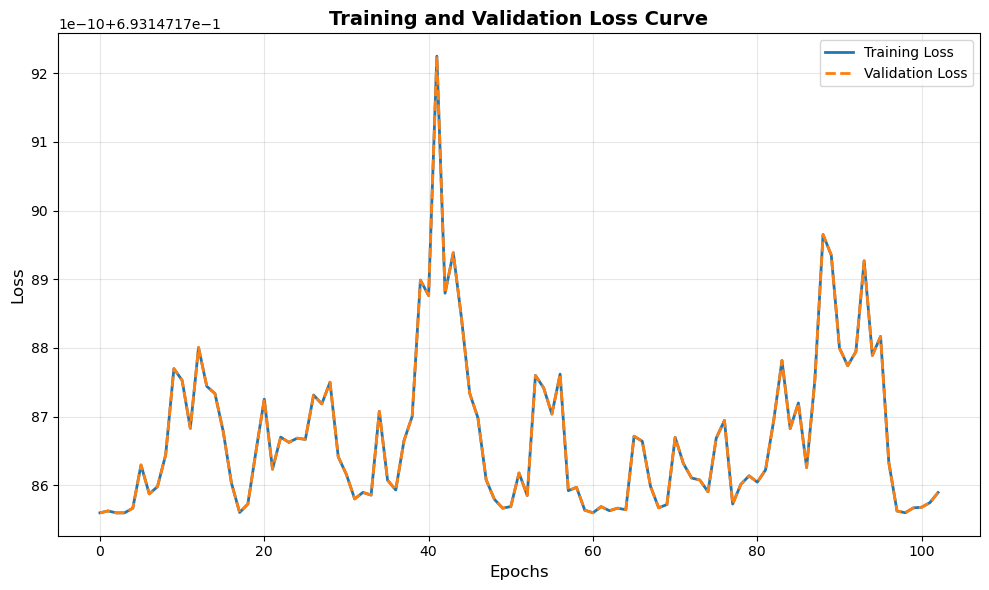

Validation Accuracy: 0.50
Confusion Matrix:
[[ 0 41]
 [ 0 41]]


In [7]:
# Defining the model object with tanh activation functions
mlp_zero_para = MLP(
    input_neurons=input_layer_neurons,
    hidden_layer_neurons=hidden_layer_neurons,
    output_neurons=output_layer_neurons,
    hidden_activation='tanh',
    output_activation='softmax',
    loss_function='cross_entropy',
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    patience=100
)

# Training the model
mlp_zero_para.weights, mlp_zero_para.biases = initialize_weights_to_zero(
    [mlp_zero_para.input_neurons] + mlp_zero_para.hidden_layer_neurons + [mlp_zero_para.output_neurons])

mlp_zero_para.train(X_train, y_train, muted=False, X_val=X_validation, y_val=y_validation)
mlp_zero_para.plot_loss()

# Make Predictions
predictions = mlp_zero_para.predict(X_validation)
true_labels = np.argmax(y_validation, axis=1)
accuracy = np.mean(predictions == true_labels)
print(f"Validation Accuracy: {accuracy:.2f}")

# Confusion matrix
y_pred = mlp_zero_para.predict(X_validation)
confusion_matrix = np.zeros((2, 2), dtype=int)
for i in range(len(true_labels)):
    confusion_matrix[true_labels[i], y_pred[i]] += 1

print('Confusion Matrix:')
print(confusion_matrix)

#### B 2. (2 points) Learning rate vs parameter initialization. 
Retrain several times for the same fixed amount of epochs (e.g. 100- this value is your choice) the best model from Part A using exactly the same settings as in Part A and the same random seed, with the exception of the learning rate and the initialization of the connection weights and biases which have to be different for each retraining. Start with a very small learning rate (e.g. 0.00001) and after that gradually increase it (e.g. next values can be 0.0001, 0.001, ...). Initialize the connection weights and biases by sampling from a normal distribution N(0,σ2)2. σ2 has to take the following values {0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1}. Make a heatmap3 where the x-axis represents σ2, the y −axis represents the learning rate, while the colors represent the accuracy4 obtained on the validation set after each training. Each element in the heatmap matrix represents practically the accuracy obtained with a specific learning rate and a specific initialization. Discuss the heatmap results.

Training with learning rate=1e-05 and variance=0
Validation Set Accuracy: 0.5000
Training with learning rate=1e-05 and variance=0.1
Validation Set Accuracy: 0.5244
Training with learning rate=1e-05 and variance=0.2
Validation Set Accuracy: 0.6098
Training with learning rate=1e-05 and variance=0.3
Validation Set Accuracy: 0.3902
Training with learning rate=1e-05 and variance=0.4
Validation Set Accuracy: 0.4756
Training with learning rate=1e-05 and variance=0.5
Validation Set Accuracy: 0.4756
Training with learning rate=1e-05 and variance=0.6
Validation Set Accuracy: 0.6585
Training with learning rate=1e-05 and variance=0.7
Validation Set Accuracy: 0.6829
Training with learning rate=1e-05 and variance=0.8
Validation Set Accuracy: 0.5488
Training with learning rate=1e-05 and variance=0.9
Validation Set Accuracy: 0.6098
Training with learning rate=1e-05 and variance=1
Validation Set Accuracy: 0.5732
Training with learning rate=1e-05 and variance=1.1
Validation Set Accuracy: 0.6220
Training

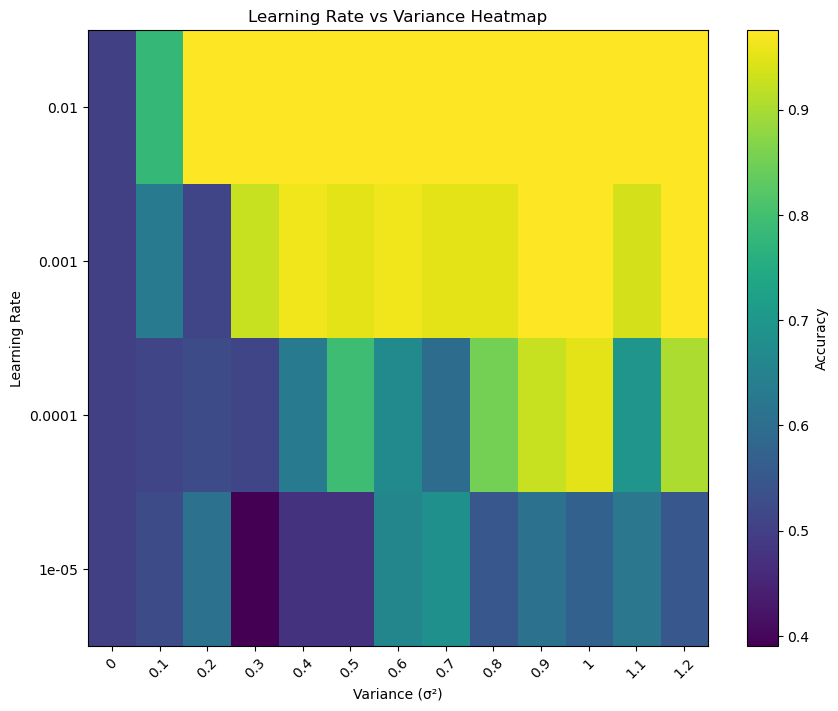

In [8]:
# Define ranges for learning rates and variances
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
variances = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
heatmap = np.zeros((len(learning_rates), len(variances)))

# Function to initialize weights with variance
def initialize_weights_with_variance(layers, variance):
    weights = []
    biases = []
    for i in range(len(layers) - 1):
        w = np.random.normal(0, variance, (layers[i], layers[i + 1]))
        b = np.zeros((1, layers[i + 1]))
        weights.append(w)
        biases.append(b)
    return weights, biases

# Train and evaluate model for each combination
for i, lr in enumerate(learning_rates):
    for j, var in enumerate(variances):
        print(f"Training with learning rate={lr} and variance={var}")
        mlp = MLP(
            input_neurons=2,
            hidden_layer_neurons=[10, 10],
            output_neurons=2,
            hidden_activation='tanh',
            output_activation='softmax',
            loss_function='cross_entropy',
            learning_rate=lr,
            batch_size=64,
            epochs=200  # Fixed epochs for comparison
        )

        # Custom weight initialization
        mlp.weights, mlp.biases = initialize_weights_with_variance(
            [mlp.input_neurons] + mlp.hidden_layer_neurons + [mlp.output_neurons], # To define the layers variable
            var
        )

        # Train the model and evaluate accuracy
        mlp.train(X_train, y_train, muted=True, X_val=X_validation, y_val=y_validation)
        accuracy = mlp.evaluate_accuracy(X_validation, y_validation, dataset_name="Validation Set")
        heatmap[i, j] = accuracy

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(heatmap, cmap='viridis', aspect='auto', origin='lower')
plt.colorbar(label="Accuracy")
plt.xticks(range(len(variances)), variances, rotation=45)
plt.yticks(range(len(learning_rates)), learning_rates)
plt.xlabel("Variance (σ²)")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Variance Heatmap")
plt.show()

#### B 3. (2 points) Activations. 
Choose the worst (one which still trains and does not give errors during training) and the best performing models from Subproblem B.2 in terms of classification accuracy. For both models, visualize the output of each hidden neuron (after applying the activation function) from the two hidden layer three times (after connection initialization before to start the training process, at half of the training process, and at the end of the training process). Visualization hints (it is optional to follow them, please feel free to be creative): you can compute the hidden neuron ouputs on the validation set where the data points are ordered per class; you can use a heatmap where x-axis represents the hidden neuron id, the y-axis represents the data points id, and the colors represent the hidden neuron ouputs. Discuss the results.

In [9]:
""" From Part B.2 
    the worst performing model is with the learning rate of 1e-05 and variance 0.3
    the best performing model is with the learning rate of 0.01 / 1e-2 and variance 1"""

# Re-creating and training the worst model
learning_rates = 1e-5
variances = 0.3

print(f"Training with learning rate={learning_rates} and variance={variances}")

mlp_worst = MLP(
    input_neurons=2,
    hidden_layer_neurons=[10, 10],
    output_neurons=2,
    hidden_activation='tanh',
    output_activation='softmax',
    loss_function='cross_entropy',
    learning_rate=learning_rates,
    batch_size=64,
    epochs=5000,  # Fixed epochs for comparison
    patience = 400
)

# Custom weight initialization
mlp_worst.weights, mlp_worst.biases = initialize_weights_with_variance(
    [mlp_worst.input_neurons] + mlp_worst.hidden_layer_neurons + [mlp_worst.output_neurons], # To define the layers variable
    variances
)

# Re-creating and training the best model
learning_rates = 0.01
variances = 1

print(f"Training with learning rate={learning_rates} and variance={variances}")
mlp_best = MLP(
    input_neurons=2,
    hidden_layer_neurons=[10, 10],
    output_neurons=2,
    hidden_activation='tanh',
    output_activation='softmax',
    loss_function='cross_entropy',
    learning_rate=learning_rates,
    batch_size=64,
    epochs=5000,  # Fixed epochs for comparison
    patience = 400
)

# Custom weight initialization
mlp_best.weights, mlp_best.biases = initialize_weights_with_variance(
    [mlp_best.input_neurons] + mlp_best.hidden_layer_neurons + [mlp_best.output_neurons], # To define the layers variable
    variances
)

Training with learning rate=1e-05 and variance=0.3
Training with learning rate=0.01 and variance=1


In [10]:
# To extract activation values
def extract_hidden_activations(mlp, X):
    activations, _ = mlp.forward(X)  # Perform forward pass
    hidden_1, hidden_2 = activations[1], activations[2]  # Extract activations
    return hidden_1, hidden_2

In [11]:
# Function to visualize the activations
def visualize_hidden_activations(hidden_1_best, hidden_2_best, hidden_1_worst, hidden_2_worst, title="Hidden Layer Activations"):

    # Best Model
    plt.figure(figsize=(12, 6))
    plt.tight_layout()
    plt.subplot(2, 2, 1)
    plt.title("Hidden Layer 1 Best Model", fontsize = 10)
    plt.imshow(hidden_1_best.T, aspect='auto', cmap='viridis')
    plt.colorbar(label="Activation Value")

    plt.subplot(2, 2, 2)
    plt.title("Hidden Layer 2 Best Model", fontsize = 10)
    plt.imshow(hidden_2_best.T, aspect='auto', cmap='viridis')
    plt.colorbar(label="Activation Value")

    # Worst Model
    plt.subplot(2, 2, 3)
    plt.title("Hidden Layer 1 Worst Model", fontsize = 10)
    plt.imshow(hidden_1_worst.T, aspect='auto', cmap='viridis')
    plt.colorbar(label="Activation Value")

    plt.subplot(2, 2, 4)
    plt.title("Hidden Layer 2 Worst Model", fontsize = 10)
    plt.imshow(hidden_2_worst.T, aspect='auto', cmap='viridis')
    plt.colorbar(label="Activation Value")

    plt.suptitle(title)
    plt.show()

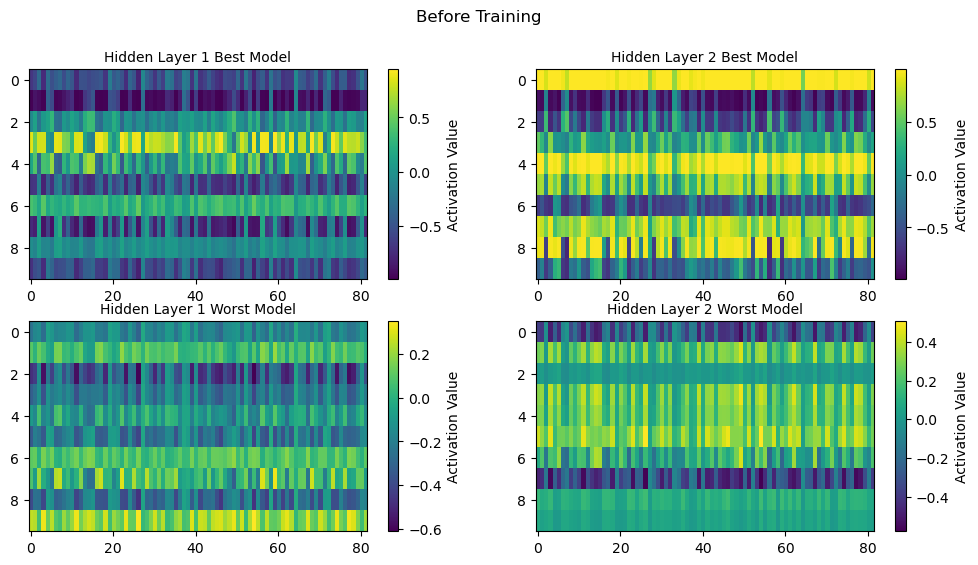

In [12]:
# Visualize the activations before training
mlp_best.set_training_mode(False)  # Disable training mode for inference
mlp_worst.set_training_mode(False)

hidden_1_best, hidden_2_best = extract_hidden_activations(mlp_best, X_validation)
hidden_1_worst, hidden_2_worst = extract_hidden_activations(mlp_worst, X_validation)

mlp_best.set_training_mode(True)  # Re-enable training mode
mlp_worst.set_training_mode(True)  # Re-enable training mode

visualize_hidden_activations(hidden_1_best, hidden_2_best, hidden_1_worst, hidden_2_worst, title="Before Training")

In [13]:
# Train the best model and evaluate accuracy
mlp_best.train(X_train, y_train, muted=False, X_val=X_validation, y_val=y_validation, save_values_at_epochs=100)
accuracy = mlp_best.evaluate_accuracy(X_validation, y_validation, dataset_name="Validation Set") 
    # Saving the value at 100 epochs because the best model terminates within 200-300 epochs

# Train the worst model and evaluate accuracy
mlp_worst.train(X_train, y_train, muted=True, X_val=X_validation, y_val=y_validation, save_values_at_epochs=epochs//2)
accuracy = mlp_worst.evaluate_accuracy(X_validation, y_validation, dataset_name="Validation Set")

Epoch 1/5000, Training Loss: 0.7031, Validation Loss: 0.6951
Epoch 201/5000, Training Loss: 0.0924, Validation Loss: 0.1245
Epoch 401/5000, Training Loss: 0.0841, Validation Loss: 0.1577
Early stopping at epoch 515
Validation Set Accuracy: 0.9756
Validation Set Accuracy: 0.5244


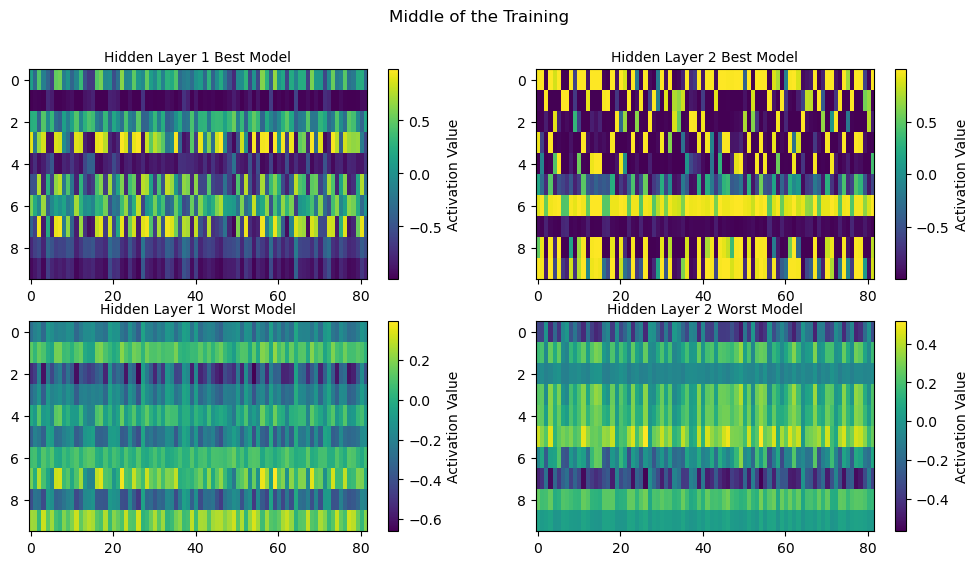

In [14]:
# Visualize the activations in the middle of the training
hidden_1_best, hidden_2_best = mlp_best.save_activation_values[1], mlp_best.save_activation_values[2]  # Extract activations
hidden_1_worst, hidden_2_worst = mlp_worst.save_activation_values[1], mlp_worst.save_activation_values[2]  # Extract activations

visualize_hidden_activations(hidden_1_best, hidden_2_best, hidden_1_worst, hidden_2_worst, title="Middle of the Training")

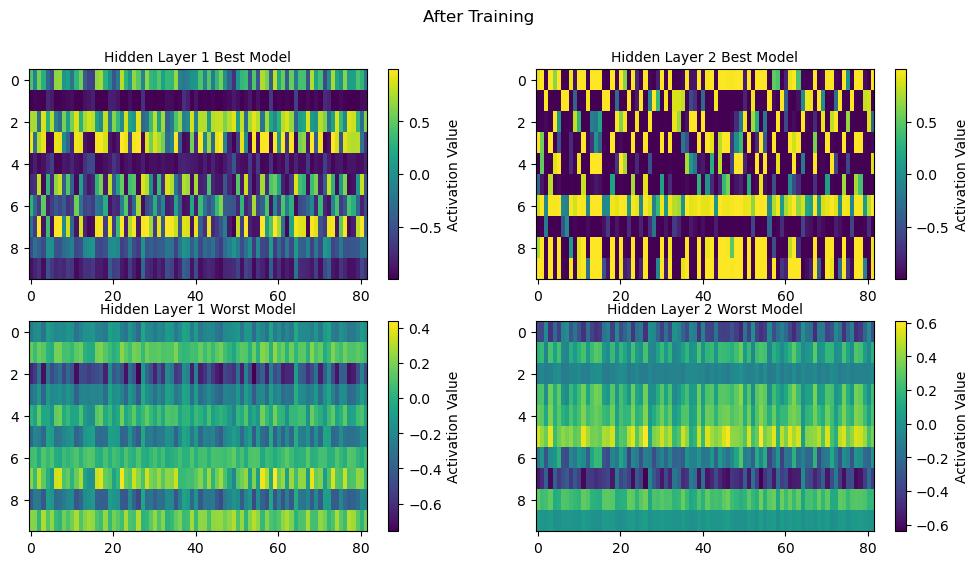

In [15]:
# Visualize the activations after training
hidden_1_best, hidden_2_best = extract_hidden_activations(mlp_best, X_validation)
hidden_1_worst, hidden_2_worst = extract_hidden_activations(mlp_worst, X_validation)

visualize_hidden_activations(hidden_1_best, hidden_2_best, hidden_1_worst, hidden_2_worst, title="After Training")

#### 4. (4 points) Hyperparameters Optimization. 
Train a MLP model on which you perform hyperparameters optimization. For this specific subproblem, you are not constraint any-more to use just two hidden layers, and 10 neurons per hidden layer. You are free to vary any hyperparameter (e.g. learning rate, number of hidden neurons per layer, type of activation function) you consider to be important to maximize the accuracy on the validation set. Please make a Parallel Coordinates Plot5 to study the effect of the hyperparameters choice on the performance. The colors of the lines which connect various hyperparameter settings represent the accuracy on the validation set. Discuss the results. For the worst and best performing models, please make a plot with the values of the loss function computed separately over the training and validation sets respectively. Discuss the generalization performance (non exclusive suggestions: overfitting, underfitting) of these two extreme models.

In [16]:
# Defining Hyperparameters
epochs = 400
muted = True
batch_size = 64
input_layer_neurons = 2
output_layer_neurons = 2
# Combinations of multiple hyperparameters
learning_rates = [0.0001, 0.001, 0.01, 0.01]
hidden_layer_neurons = [[5,5],[10,10],[20,20],[5,5,5],[10,10,10], [10,10,10,10]]
variances = [0.1, 0.2, 0.5, 0.8, 1]

results = pd.DataFrame(columns=['Variance','Hidden Neurons','Hidden Layers','Learning Rate','Accuracy'])   # To store the results
index = 0

# Training the models with different hyperparameters
for learning_rate in learning_rates:
    for hl_neurons in hidden_layer_neurons:
        for variance in variances:
            mlp = MLP(
                input_neurons=input_layer_neurons,
                hidden_layer_neurons=hl_neurons,
                output_neurons=output_layer_neurons,
                hidden_activation='tanh',
                output_activation='softmax',
                loss_function='cross_entropy',
                learning_rate=learning_rate,
                batch_size=batch_size,
                epochs=epochs,
                patience=200
                )

            mlp.weights, mlp.biases = initialize_weights_with_variance([mlp.input_neurons] + mlp.hidden_layer_neurons + [mlp.output_neurons], variance)

            # Train the model and evaluate accuracy
            mlp.train(X_train, y_train, muted=True, X_val=X_validation, y_val=y_validation)
            accuracy = mlp.evaluate_accuracy(X_validation, y_validation, dataset_name="Validation Set")

            new_row = pd.DataFrame({'Variance':[variance],
                                    'Hidden Neurons':[np.average(hl_neurons)],
                                    'Hidden Layers':[len(hl_neurons)],
                                    'Learning Rate':[learning_rate],
                                    'Accuracy':[accuracy]})
            # Storing the results
            results = pd.concat([results, new_row], ignore_index=True)
            

Validation Set Accuracy: 0.5000


C:\Users\prave\AppData\Local\Temp\ipykernel_20972\1118612796.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


Validation Set Accuracy: 0.5244
Validation Set Accuracy: 0.5122
Validation Set Accuracy: 0.9390
Validation Set Accuracy: 0.9146
Validation Set Accuracy: 0.5244
Validation Set Accuracy: 0.5366
Validation Set Accuracy: 0.7683
Validation Set Accuracy: 0.9024
Validation Set Accuracy: 0.9390
Validation Set Accuracy: 0.5244
Validation Set Accuracy: 0.5976
Validation Set Accuracy: 0.9268
Validation Set Accuracy: 0.9390
Validation Set Accuracy: 0.9390
Validation Set Accuracy: 0.4390
Validation Set Accuracy: 0.5122
Validation Set Accuracy: 0.6707
Validation Set Accuracy: 0.9512
Validation Set Accuracy: 0.9268
Validation Set Accuracy: 0.5000
Validation Set Accuracy: 0.5366
Validation Set Accuracy: 0.9268
Validation Set Accuracy: 0.9390
Validation Set Accuracy: 0.9756
Validation Set Accuracy: 0.5122
Validation Set Accuracy: 0.4512
Validation Set Accuracy: 0.9390
Validation Set Accuracy: 0.9390
Validation Set Accuracy: 0.9756
Validation Set Accuracy: 0.4024
Validation Set Accuracy: 0.5122
Validati

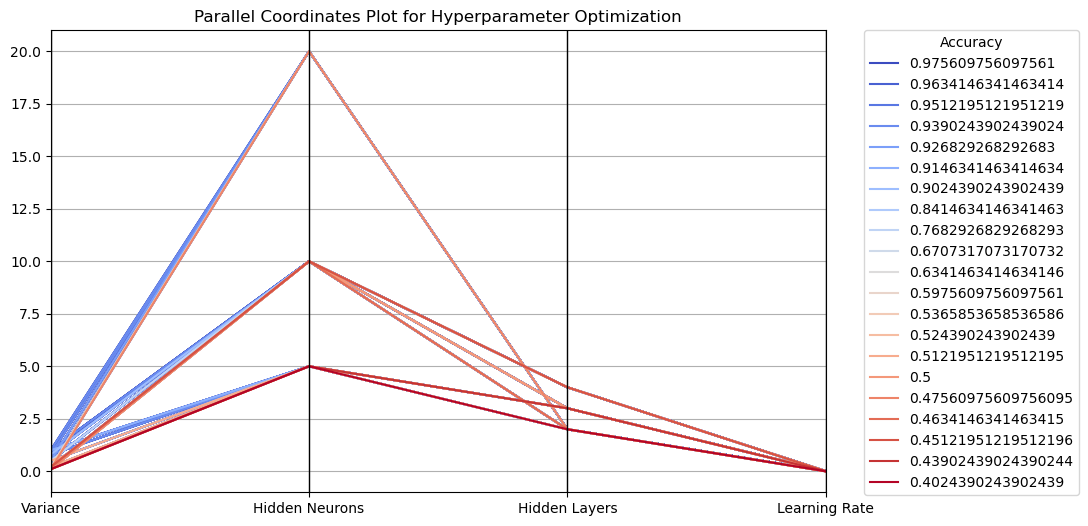

In [17]:
# For Parallel coordinates plot
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler

results = results.sort_values(by="Accuracy", ascending=False)

plt.figure(figsize=(10, 6))
parallel_coordinates(results, 'Accuracy', colormap='coolwarm')
plt.title("Parallel Coordinates Plot for Hyperparameter Optimization")
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    title='Accuracy',
    borderaxespad=0
)
plt.show()

In [18]:
# Min - Max scaling results 
scaler = MinMaxScaler()
scaled_results = scaler.fit_transform(results[['Variance','Hidden Neurons','Hidden Layers','Learning Rate','Accuracy']])
scaled_results_df = pd.DataFrame(scaled_results, columns =['Variance','Hidden Neurons','Hidden Layers','Learning Rate','Accuracy'])

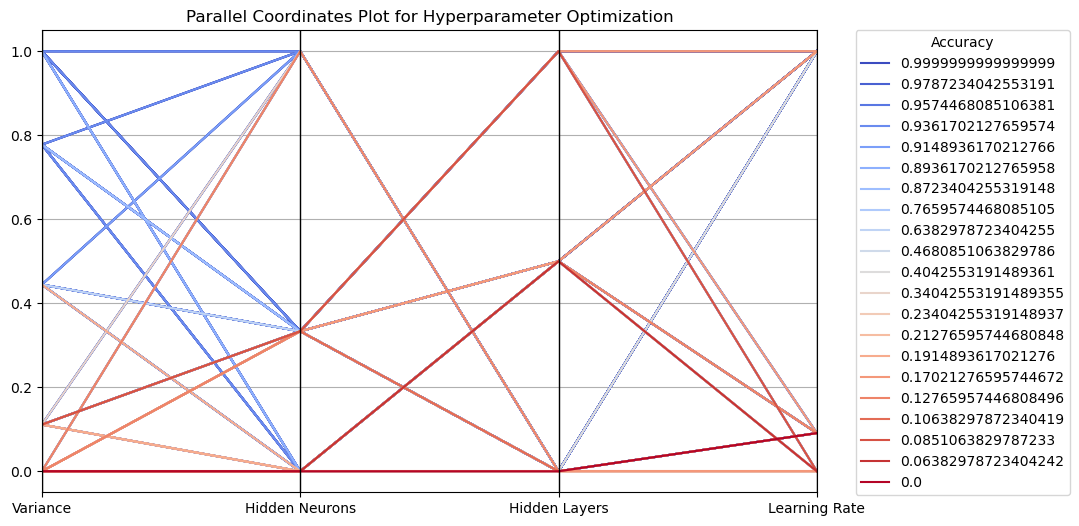

In [19]:
# Parallel Coordinates Plot of the scaled results
plt.figure(figsize=(10, 6))
parallel_coordinates(scaled_results_df, 'Accuracy', colormap='coolwarm')
plt.title("Parallel Coordinates Plot for Hyperparameter Optimization")
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    title='Accuracy',
    borderaxespad=0
)
plt.show()

 # Bonus exercise (4 points)
 #### 1. (optional) Regularization. 
Add L1 and L2 regularization techniques to the neural network you previously developed. Take the best hyperparameters from the last section and use them to train the network with each regularization type. For each model (L1 and L2), report the classification accuracy. Generate and include a confusion matrix for each model to visualize performance. Discuss any differences in performance, particularly focusing on the classification accuracy and confusion matrix values. Additionally discuss the extent to which weights have been reduced in magnitude. How many weights have become exactly zero (this is more likely with L1 regularization)?

In [20]:
results.head(1)   # The best model from part B4

,Variance,Hidden Neurons,Hidden Layers,Learning Rate,Accuracy
44,1.0,20.0,2,0.001,0.97561


In [26]:
# Define the MLP class with L1 an L2 Regularization
class MLP_with_L1_L2:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, l1=0.0, l2=0.0):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.l1 = l1
        self.l2 = l2
        
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size1) * 1
        self.b1 = np.zeros(hidden_size1)
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * 1
        self.b2 = np.zeros(hidden_size2)
        self.W3 = np.random.randn(hidden_size2, output_size) * 1
        self.b3 = np.zeros(output_size)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.relu(self.Z2)
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.sigmoid(self.Z3)
        return self.A3

    def compute_loss(self, y_true, y_pred):
        # Binary cross-entropy loss
        m = y_true.shape[0]
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

        # L1 and L2 regularization
        l1_loss = self.l1 * (np.sum(np.abs(self.W1)) + np.sum(np.abs(self.W2)) + np.sum(np.abs(self.W3)))
        l2_loss = self.l2 * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2) + np.sum(self.W3 ** 2))

        return loss + l1_loss + l2_loss

    def backward(self, X, y_true, y_pred):
        m = y_true.shape[0]

        # Gradients of output layer
        dZ3 = y_pred - y_true
        dW3 = (1 / m) * np.dot(self.A2.T, dZ3) + self.l1 * np.sign(self.W3) + 2 * self.l2 * self.W3
        db3 = (1 / m) * np.sum(dZ3, axis=0)

        # Gradients of second hidden layer
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)
        dW2 = (1 / m) * np.dot(self.A1.T, dZ2) + self.l1 * np.sign(self.W2) + 2 * self.l2 * self.W2
        db2 = (1 / m) * np.sum(dZ2, axis=0)

        # Gradients of first hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = (1 / m) * np.dot(X.T, dZ1) + self.l1 * np.sign(self.W1) + 2 * self.l2 * self.W1
        db1 = (1 / m) * np.sum(dZ1, axis=0)

        # Update weights and biases
        return dW1, db1, dW2, db2, dW3, db3

    def update_params(self, dW1, db1, dW2, db2, dW3, db3, lr):
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W3 -= lr * dW3
        self.b3 -= lr * db3

    def train(self, X, y, epochs, lr):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y, y_pred)
            
            dW1, db1, dW2, db2, dW3, db3 = self.backward(X, y, y_pred)
            self.update_params(dW1, db1, dW2, db2, dW3, db3, lr)

            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        y_pred = self.forward(X)
        return (y_pred > 0.5).astype(int)

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

In [27]:
# Confusion Matrix
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tp, fn], [fp, tn]])

# Analyze weight magnitudes
def analyze_weights(W):
    total_weights = W.size
    zero_weights = np.sum(W == 0)
    reduced_magnitude = np.sum(np.abs(W) < 0.01)  # Consider small weights as reduced
    return total_weights, zero_weights, reduced_magnitude

In [44]:
# Read the data
train_data = pd.read_excel(train_file_path)
validate_data = pd.read_excel(validation_file_path)

# Prepare the data
X_train = train_data[["X_0", "X_1"]].values
y_train = train_data["y"].values

X_val = validate_data[["X_0", "X_1"]].values
y_val = validate_data["y"].values

# Normalize the features
def normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

X_train = normalize(X_train)
X_val = normalize(X_val)

In [49]:
# Training with L1 Regularization
print("------ L1 Regularization ------")
input_size = X_train.shape[1]
hidden_size1 = 20
hidden_size2 = 20
output_size = 1
variance = 1
l1 = 0.001
l2 = 0
learning_rate = 0.01
epochs = 200
# Train the MLP model
mlp = MLP_with_L1_L2(input_size, hidden_size1, hidden_size2, output_size, l1, l2)
mlp.train(X_train, y_train.reshape(-1, 1), epochs, learning_rate)

# Evaluate on the validation set
y_val_pred = mlp.predict(X_val)
accuracy = np.mean(y_val_pred.flatten() == y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_val, y_val_pred.flatten())
print("Confusion Matrix:")
print(cm)

for i, W in enumerate([mlp.W1, mlp.W2, mlp.W3], start=1):
    total, zero, reduced = analyze_weights(W)
    print(f"Layer {i}: Total weights = {total}, Zero weights = {zero}, Weights reduced in magnitude = {reduced}")

# Training with L2 Regularization
print("------ L2 Regularization ------")
input_size = X_train.shape[1]
hidden_size1 = 20
hidden_size2 = 20
output_size = 1
variance = 1
l1 = 0
l2 = 0.001
learning_rate = 0.01
epochs = 200
# Train the MLP model
mlp = MLP_with_L1_L2(input_size, hidden_size1, hidden_size2, output_size, l1, l2)
mlp.train(X_train, y_train.reshape(-1, 1), epochs, learning_rate)

# Evaluate on the validation set
y_val_pred = mlp.predict(X_val)
accuracy = np.mean(y_val_pred.flatten() == y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_val, y_val_pred.flatten())
print("Confusion Matrix:")
print(cm)

for i, W in enumerate([mlp.W1, mlp.W2, mlp.W3], start=1):
    total, zero, reduced = analyze_weights(W)
    print(f"Layer {i}: Total weights = {total}, Zero weights = {zero}, Weights reduced in magnitude = {reduced}")

------ L1 Regularization ------
Epoch 100/200, Loss: 0.5480
Epoch 200/200, Loss: 0.5090
Validation Accuracy: 0.9634
Confusion Matrix:
[[40  1]
 [ 2 39]]
Layer 1: Total weights = 40, Zero weights = 0, Weights reduced in magnitude = 0
Layer 2: Total weights = 400, Zero weights = 0, Weights reduced in magnitude = 6
Layer 3: Total weights = 20, Zero weights = 0, Weights reduced in magnitude = 0
------ L2 Regularization ------
Epoch 100/200, Loss: 0.6902
Epoch 200/200, Loss: 0.6562
Validation Accuracy: 0.9756
Confusion Matrix:
[[40  1]
 [ 1 40]]
Layer 1: Total weights = 40, Zero weights = 0, Weights reduced in magnitude = 2
Layer 2: Total weights = 400, Zero weights = 0, Weights reduced in magnitude = 0
Layer 3: Total weights = 20, Zero weights = 0, Weights reduced in magnitude = 2


### ------------------------------------------------ END -----------------------------------------------------